# Sentinel-2 Martinique


This tutorial is an introduction to masking clouds and cloud shadows in Sentinel-2 (S2) surface reflectance (SR) data using Earth Engine. Clouds are identified from the S2 cloud probability dataset (s2cloudless) and shadows are defined by cloud projection intersection with low-reflectance near-infrared (NIR) pixels.

### Run me first

Run the following cell to initialize the Earth Engine API. The output will contain instructions on how to grant this notebook access to Earth Engine using your account.

In [1]:
import ee

service_account = 'slums-detection-sa@ee-insee-sentinel.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, '../GCP_credentials.json')

# Initialize the library.
ee.Initialize(credentials)

## Assemble cloud mask components

This section builds an S2 SR collection and defines functions to add cloud and cloud shadow component layers to each image in the collection.



### Define collection filter and cloud mask parameters

Define parameters that are used to filter the S2 image collection and determine cloud and cloud shadow identification.

|Parameter | Type | Description |
| :-- | :-- | :-- |
| `AOI` | `ee.Geometry` | Area of interest |
| `START_DATE` | string | Image collection start date (inclusive) |
| `END_DATE` | string | Image collection end date (exclusive) |
| `CLOUD_FILTER` | integer | Maximum image cloud cover percent allowed in image collection |
| `CLD_PRB_THRESH` | integer | Cloud probability (%); values greater than are considered cloud |
| `NIR_DRK_THRESH` | float | Near-infrared reflectance; values less than are considered potential cloud shadow |
| `CLD_PRJ_DIST` | float | Maximum distance (km) to search for cloud shadows from cloud edges |
| `BUFFER` | integer | Distance (m) to dilate the edge of cloud-identified objects |

The values currently set for `AOI`, `START_DATE`, `END_DATE`, and `CLOUD_FILTER` are intended to build a collection for a single S2 overpass of a region near Portland, Oregon, USA. When parameterizing and evaluating cloud masks for a new area, it is good practice to identify a single overpass date and limit the regional extent to minimize processing requirements. If you want to work with a different example, use this [Earth Engine App](https://showcase.earthengine.app/view/s2-sr-browser-s2cloudless-nb) to identify an image that includes some clouds, then replace the relevant parameter values below with those provided in the app.

**Martinique : on a récupérér des coordonnées sur l'app ci-dessus.**

In [2]:
AOI = ee.Geometry.Point(-61.07, 14.616)
START_DATE = '2020-03-01'
END_DATE = '2020-06-02'
CLOUD_FILTER = 60
CLD_PRB_THRESH = 50
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 1
BUFFER = 50

In [3]:
west = -61.264617
south = 14.378599
east = -60.781573
north = 14.899453
AOI = ee.Geometry.BBox(west, south, east, north)

### Build a Sentinel-2 collection

[Sentinel-2 surface reflectance](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR) and [Sentinel-2 cloud probability](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_CLOUD_PROBABILITY) are two different image collections. Each collection must be filtered similarly (e.g., by date and bounds) and then the two filtered collections must be joined.

Define a function to filter the SR and s2cloudless collections according to area of interest and date parameters, then join them on the `system:index` property. The result is a copy of the SR collection where each image has a new `'s2cloudless'` property whose value is the corresponding s2cloudless image.

In [4]:
def get_s2_sr_cld_col(aoi, start_date, end_date):
    # Import and filter S2 SR.
    s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_SR')
        .filterBounds(aoi)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER)))

    # Import and filter s2cloudless.
    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

Apply the `get_s2_sr_cld_col` function to build a collection according to the parameters defined above.

In [5]:
s2_sr_cld_col_eval = get_s2_sr_cld_col(AOI, START_DATE, END_DATE)

### Define cloud mask component functions

#### Cloud components

Define a function to add the s2cloudless probability layer and derived cloud mask as bands to an S2 SR image input.

In [6]:
def add_cloud_bands(img):
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))

#### Cloud shadow components

Define a function to add dark pixels, cloud projection, and identified shadows as bands to an S2 SR image input. Note that the image input needs to be the result of the above `add_cloud_bands` function because it relies on knowing which pixels are considered cloudy (`'clouds'` band).

In [7]:
def add_shadow_bands(img):
    # Identify water pixels from the SCL band.
    not_water = img.select('SCL').neq(6)

    # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

    # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    # Identify the intersection of dark pixels with cloud shadow projection.
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    # Add dark pixels, cloud projection, and identified shadows as image bands.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

#### Final cloud-shadow mask

Define a function to assemble all of the cloud and cloud shadow components and produce the final mask.

In [8]:
def add_cld_shdw_mask(img):
    # Add cloud component bands.
    img_cloud = add_cloud_bands(img)

    # Add cloud shadow component bands.
    img_cloud_shadow = add_shadow_bands(img_cloud)

    # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

    # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
    # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
    is_cld_shdw = (is_cld_shdw.focalMin(2).focalMax(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))

    # Add the final cloud-shadow mask to the image.
    return img_cloud_shadow.addBands(is_cld_shdw)

## Visualize and evaluate cloud mask components

This section provides functions for displaying the cloud and cloud shadow components. In most cases, adding all components to images and viewing them is unnecessary. This section is included to illustrate how the cloud/cloud shadow mask is developed and demonstrate how to test and evaluate various parameters, which is helpful when defining masking variables for an unfamiliar region or time of year.

In applications outside of this tutorial, if you prefer to include only the final cloud/cloud shadow mask along with the original image bands, replace:

```
return img_cloud_shadow.addBands(is_cld_shdw)
```

with

```
return img.addBands(is_cld_shdw)
```

in the above `add_cld_shdw_mask` function.

### Define functions to display image and mask component layers.

Folium will be used to display map layers. Import `folium` and define a method to display Earth Engine image tiles.

In [9]:
# Import the folium library.
import folium

# Define a method for displaying Earth Engine image tiles to a folium map.
def add_ee_layer(self, ee_image_object, vis_params, name, show=True, opacity=1, min_zoom=0):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        show=show,
        opacity=opacity,
        min_zoom=min_zoom,
        overlay=True,
        control=True
        ).add_to(self)

# Add the Earth Engine layer method to folium.
folium.Map.add_ee_layer = add_ee_layer

Define a function to display all of the cloud and cloud shadow components to an interactive Folium map. The input is an image collection where each image is the result of the `add_cld_shdw_mask` function defined previously.

In [10]:
def display_cloud_layers(col):
    # Mosaic the image collection.
    img = col.mosaic()

    # Subset layers and prepare them for display.
    clouds = img.select('clouds').selfMask()
    shadows = img.select('shadows').selfMask()
    dark_pixels = img.select('dark_pixels').selfMask()
    probability = img.select('probability')
    cloudmask = img.select('cloudmask').selfMask()
    cloud_transform = img.select('cloud_transform')

    # Create a folium map object.
    center = AOI.centroid(10).coordinates().reverse().getInfo()
    m = folium.Map(location=center, zoom_start=12)

    # Add layers to the folium map.
    m.add_ee_layer(img,
                   {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2500, 'gamma': 1.1},
                   'S2 image', True, 1, 9)
    m.add_ee_layer(probability,
                   {'min': 0, 'max': 100},
                   'probability (cloud)', False, 1, 9)
    m.add_ee_layer(clouds,
                   {'palette': 'e056fd'},
                   'clouds', False, 1, 9)
    m.add_ee_layer(cloud_transform,
                   {'min': 0, 'max': 1, 'palette': ['white', 'black']},
                   'cloud_transform', False, 1, 9)
    m.add_ee_layer(dark_pixels,
                   {'palette': 'orange'},
                   'dark_pixels', False, 1, 9)
    m.add_ee_layer(shadows, {'palette': 'yellow'},
                   'shadows', False, 1, 9)
    m.add_ee_layer(cloudmask, {'palette': 'orange'},
                   'cloudmask', True, 0.5, 9)

    # Add a layer control panel to the map.
    m.add_child(folium.LayerControl())

    # Display the map.
    display(m)

### Display mask component layers

Map the `add_cld_shdw_mask` function over the collection to add mask component bands to each image, then display the results.

Give the system some time to render everything, it should take less than a minute.

In [11]:
s2_sr_cld_col_eval_disp = s2_sr_cld_col_eval.map(add_cld_shdw_mask)

display_cloud_layers(s2_sr_cld_col_eval_disp)

In [12]:
s2_sr_cld_col_eval_disp

In [13]:
import geemap
geemap.ee_export_image_collection(s2_sr_cld_col_eval_disp, "martinique_collection/", scale=30, crs="epsg:4559", region=AOI, file_per_band=True)

Total number of images: 131

Exporting 1/131: martinique_collection/20200302T144729_20200302T144723_T20PPA.tif
Generating URL ...
An error occurred while downloading.
Total request size (281670792 bytes) must be less than or equal to 50331648 bytes.


Exporting 2/131: martinique_collection/20200302T144729_20200302T144723_T20PPB.tif
Generating URL ...
An error occurred while downloading.
Total request size (281670792 bytes) must be less than or equal to 50331648 bytes.


Exporting 3/131: martinique_collection/20200302T144729_20200302T144723_T20PQB.tif
Generating URL ...
An error occurred while downloading.
Total request size (281670792 bytes) must be less than or equal to 50331648 bytes.


Exporting 4/131: martinique_collection/20200304T143721_20200304T143722_T20PPA.tif
Generating URL ...
An error occurred while downloading.
Total request size (281670792 bytes) must be less than or equal to 50331648 bytes.


Exporting 5/131: martinique_collection/20200304T143721_20200304T143722_T20PPB.t


KeyboardInterrupt



### Evaluate mask component layers

In the above map, use the layer control panel in the upper right corner to toggle layers on and off; layer names are the same as band names, for easy code referral. Note that the layers have a minimum zoom level of 9 to avoid resource issues that can occur when visualizing layers that depend on the `ee.Image.reproject` function (used during cloud shadow project and mask dilation).

Try changing the above `CLD_PRB_THRESH`, `NIR_DRK_THRESH`, `CLD_PRJ_DIST`, and `BUFFER` input variables and rerunning the previous cell to see how the results change. Find a good set of values for a given overpass and then try the procedure with a new overpass with different cloud conditions (this [S2 SR image browser app](https://showcase.earthengine.app/view/s2-sr-browser-s2cloudless-nb) is handy for quickly identifying images and determining image collection filter criteria). Try to identify a set of parameter values that balances cloud/cloud shadow commission and omission error for a range of cloud types. In the next section, we'll use the values to actually apply the mask to generate a cloud-free composite for 2020.

## Apply cloud and cloud shadow mask

In this section we'll generate a cloud-free composite for the same region as above that represents mean reflectance for July and August, 2020.

### Define collection filter and cloud mask parameters

We'll redefine the parameters to be a little more aggressive, i.e. decrease the cloud probability threshold, increase the cloud projection distance, and increase the buffer. These changes will increase cloud commission error (mask out some clear pixels), but since we will be compositing images from three months, there should be plenty of observations to complete the mosaic.

In [14]:
START_DATE = '2020-06-01'
END_DATE = '2020-09-01'
CLOUD_FILTER = 60
CLD_PRB_THRESH = 40
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 2
BUFFER = 100

### Build a Sentinel-2 collection

Reassemble the S2-cloudless collection since the collection filter parameters have changed.

In [ ]:
s2_sr_cld_col = get_s2_sr_cld_col(AOI, START_DATE, END_DATE)

### Define cloud mask application function

Define a function to apply the cloud mask to each image in the collection.

In [ ]:
def apply_cld_shdw_mask(img):
    # Subset the cloudmask band and invert it so clouds/shadow are 0, else 1.
    not_cld_shdw = img.select('cloudmask').Not()

    # Subset reflectance bands and update their masks, return the result.
    return img.select('B.*').updateMask(not_cld_shdw)

### Process the collection

Add cloud and cloud shadow component bands to each image and then apply the mask to each image. Reduce the collection by median (in your application, you might consider using medoid reduction to build a composite from actual data values, instead of per-band statistics).

In [ ]:
s2_sr_median = (s2_sr_cld_col.map(add_cld_shdw_mask)
                             .map(apply_cld_shdw_mask)
                             .median())

### Display the cloud-free composite

Display the results. Be patient while the map renders, it may take a minute; [`ee.Image.reproject`](https://developers.google.com/earth-engine/guides/projections#reprojecting) is forcing computations to happen at 100 and 20 m scales (i.e. it is not relying on appropriate pyramid level [scales for analysis](https://developers.google.com/earth-engine/guides/scale#scale-of-analysis)). The issues with `ee.Image.reproject` being resource-intensive in this case are mostly confined to interactive map viewing. Batch image [exports](https://developers.google.com/earth-engine/guides/exporting) and table reduction exports where the `scale` parameter is set to typical Sentinel-2 scales (10-60 m) are less affected.



In [ ]:
# Create a folium map object.
center = AOI.centroid(10).coordinates().reverse().getInfo()
m = folium.Map(location=center, zoom_start=12)

# Add layers to the folium map.
m.add_ee_layer(s2_sr_median,
                {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2500, 'gamma': 1.1},
                'S2 cloud-free mosaic', True, 1, 9)

# Add a layer control panel to the map.
m.add_child(folium.LayerControl())

# Display the map.
display(m)

Visiblement la fenêtre choisie de 3 mois ne suffit pas pour avoir une couverture complète du territoire sans nuage... 6 mois ?

Hopefully you now have a good sense for Sentinel-2 cloud masking in the cloud 😉 with Earth Engine.

In [15]:
START_DATE = '2020-03-01'
END_DATE = '2020-09-01'
CLOUD_FILTER = 60
CLD_PRB_THRESH = 40
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 2
BUFFER = 100

### Build a Sentinel-2 collection

Reassemble the S2-cloudless collection since the collection filter parameters have changed.

In [16]:
s2_sr_cld_col = get_s2_sr_cld_col(AOI, START_DATE, END_DATE)

### Define cloud mask application function

Define a function to apply the cloud mask to each image in the collection.

In [17]:
def apply_cld_shdw_mask(img):
    # Subset the cloudmask band and invert it so clouds/shadow are 0, else 1.
    not_cld_shdw = img.select('cloudmask').Not()

    # Subset reflectance bands and update their masks, return the result.
    return img.select('B.*').updateMask(not_cld_shdw)

### Process the collection

Add cloud and cloud shadow component bands to each image and then apply the mask to each image. Reduce the collection by median (in your application, you might consider using medoid reduction to build a composite from actual data values, instead of per-band statistics).

In [18]:
s2_sr_median = (s2_sr_cld_col.map(add_cld_shdw_mask)
                             .map(apply_cld_shdw_mask)
                             .median())

### Display the cloud-free composite

Display the results. Be patient while the map renders, it may take a minute; [`ee.Image.reproject`](https://developers.google.com/earth-engine/guides/projections#reprojecting) is forcing computations to happen at 100 and 20 m scales (i.e. it is not relying on appropriate pyramid level [scales for analysis](https://developers.google.com/earth-engine/guides/scale#scale-of-analysis)). The issues with `ee.Image.reproject` being resource-intensive in this case are mostly confined to interactive map viewing. Batch image [exports](https://developers.google.com/earth-engine/guides/exporting) and table reduction exports where the `scale` parameter is set to typical Sentinel-2 scales (10-60 m) are less affected.



In [19]:
# Create a folium map object.
center = AOI.centroid(10).coordinates().reverse().getInfo()
m = folium.Map(location=center, zoom_start=12)

# Add layers to the folium map.
m.add_ee_layer(s2_sr_median,
                {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2500, 'gamma': 1.1},
                'S2 cloud-free mosaic', True, 1, 9)

# Add a layer control panel to the map.
m.add_child(folium.LayerControl())

# Display the map.
display(m)

Ok avec 6 mois on a toujours quelques trous, mais peut-être qu'on peut relâcher certains filtres initiaux ? (cloud coverage)

## Téléchargement des données

In [21]:
!pip install geedim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 kB 3.1 MB/s eta 0:00:00


In [22]:
fishnet = geemap.fishnet(AOI, rows=4, cols=4)
geemap.download_ee_image_tiles(s2_sr_median, fishnet, "martinique_test/", prefix="sentinel2_", crs="EPSG:4559", scale=30)

sentinel2_01.tif: |          | 0.00/20.4M (raw) [  0.0%] in 00:00 (eta:     ?)

There is no STAC entry for: None


sentinel2_02.tif: |          | 0.00/20.4M (raw) [  0.0%] in 00:00 (eta:     ?)

sentinel2_03.tif: |          | 0.00/20.4M (raw) [  0.0%] in 00:00 (eta:     ?)

sentinel2_04.tif: |          | 0.00/20.5M (raw) [  0.0%] in 00:00 (eta:     ?)

sentinel2_05.tif: |          | 0.00/20.5M (raw) [  0.0%] in 00:00 (eta:     ?)

sentinel2_06.tif: |          | 0.00/20.4M (raw) [  0.0%] in 00:00 (eta:     ?)

sentinel2_07.tif: |          | 0.00/20.4M (raw) [  0.0%] in 00:00 (eta:     ?)

sentinel2_08.tif: |          | 0.00/20.4M (raw) [  0.0%] in 00:00 (eta:     ?)

sentinel2_09.tif: |          | 0.00/20.5M (raw) [  0.0%] in 00:00 (eta:     ?)

sentinel2_10.tif: |          | 0.00/20.5M (raw) [  0.0%] in 00:00 (eta:     ?)

sentinel2_11.tif: |          | 0.00/20.4M (raw) [  0.0%] in 00:00 (eta:     ?)

sentinel2_12.tif: |          | 0.00/20.4M (raw) [  0.0%] in 00:00 (eta:     ?)

sentinel2_13.tif: |          | 0.00/20.4M (raw) [  0.0%] in 00:00 (eta:     ?)

sentinel2_14.tif: |          | 0.00/20.5M (raw) [  0.0%] in 00:00 (eta:     ?)

sentinel2_15.tif: |          | 0.00/20.5M (raw) [  0.0%] in 00:00 (eta:     ?)

sentinel2_16.tif: |          | 0.00/20.4M (raw) [  0.0%] in 00:00 (eta:     ?)

sentinel2_17.tif: |          | 0.00/20.4M (raw) [  0.0%] in 00:00 (eta:     ?)

sentinel2_18.tif: |          | 0.00/20.5M (raw) [  0.0%] in 00:00 (eta:     ?)

sentinel2_19.tif: |          | 0.00/20.5M (raw) [  0.0%] in 00:00 (eta:     ?)

sentinel2_20.tif: |          | 0.00/20.4M (raw) [  0.0%] in 00:00 (eta:     ?)

sentinel2_21.tif: |          | 0.00/20.4M (raw) [  0.0%] in 00:00 (eta:     ?)

sentinel2_22.tif: |          | 0.00/20.4M (raw) [  0.0%] in 00:00 (eta:     ?)

sentinel2_23.tif: |          | 0.00/20.4M (raw) [  0.0%] in 00:00 (eta:     ?)

sentinel2_24.tif: |          | 0.00/20.4M (raw) [  0.0%] in 00:00 (eta:     ?)

sentinel2_25.tif: |          | 0.00/20.5M (raw) [  0.0%] in 00:00 (eta:     ?)

Il manquait un delta au fishnet ! Aussi il ne faudrait pas avoir de prefix... Loading .tif data

In [23]:
!pip install rasterio

In [25]:
import rasterio
dataset = rasterio.open('martinique_test/sentinel2_07.tif')

In [26]:
dataset.bounds

BoundingBox(left=699900.0, bottom=1604790.0, right=713070.0, top=1619340.0)

Number of bands

In [27]:
dataset.count

12

12 bandes, normal ?

In [28]:
dataset.width

439

In [29]:
dataset.height

485

In [30]:
dataset.read((4, 2, 3)).shape

(3, 485, 439)

In [34]:
dataset.read(4)

array([[ 454. ,  467. ,  428.5, ..., 1432. ,  772. ,  498. ],
       [ 445. ,  459. ,  438. , ..., 1534. , 1457. , 2271. ],
       [ 457. ,  474. ,  481. , ...,  960. ,  870. , 1272. ],
       ...,
       [ 695. ,  753. ,  777. , ...,  365.5,  381. ,  444. ],
       [ 641. ,  718. ,  763. , ...,  359. ,  418. ,  417. ],
       [ 694. ,  718. ,  779. , ...,  332.5,  432. ,  452. ]])

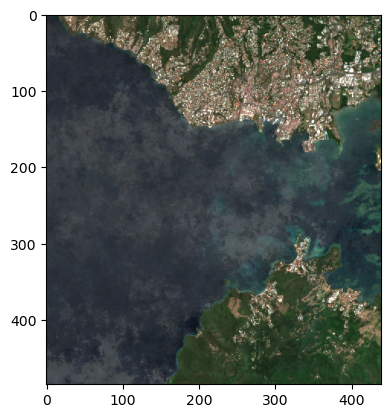

In [38]:
from matplotlib import pyplot
import numpy as np

normalized_img = np.moveaxis(dataset.read((4, 3, 2)), 0, -1) / 10000
normalized_img = np.clip(normalized_img, 0, 0.3) / 0.3
normalized_img = (normalized_img * 255).astype(np.uint8)

pyplot.imshow(normalized_img)